# Reinforce Learning in Asset Allocation

**Author: ZHONG, Ziyu & ZHONG, Jingwen** &nbsp;&nbsp;&nbsp; **Student Number: 20923387 & 20930225**

## 1 The Asset Allocation Problem

Consider the discrete-time asset allocation example in section 8.4 of *Rao and Jelvis*. Suppose the single-time-step return of the risky asset from time $t$ to $t+1$ as $Y_t = a, prob = p$, and $b, prob = (1-p)$ .  Suppose that $T =10$, use the TD method to find the Q function, and hence the optimal strategy.

## 1.1 Problem Setting

We are given wealth $W_0$ at time $0$. At each of discrete time steps labeled $t = 0, 1, . . . , T − 1$, we are allowed to allocate the wealth $W_t$ at time $t$ to a portfolio of a risky asset and a riskless asset in an unconstrained manner with no transaction costs. The risky asset yields a random return $Y_t$ over each single time step. The riskless asset yields a constant return denoted by $r$ over each single time step (for a given $r\in \mathbb{R}$). We assume that there is no consumption of wealth at any time $t < T$, and that we liquidate and consume the wealth $W_T$ at time $T$. So our goal is simply to maximize the Expected Utility of Wealth at the final time step $t = T$ by dynamically allocating $x_t\in \mathbb{R}$ in the risky asset and the remaining $W_t − x_t$ in the riskless asset for each $t = 0, 1, . . . , T − 1$. Assume the single-time-step discount factor is $\gamma$ and that the Utility of Wealth at the final time step $t = T$ is given by the following CARA function:

$$U(W_T) = \dfrac{1-e^{-cW_T}}{c} \text{for some fixed c}\neq 0$$ 

Thus, the problem is to maximize, for each $t = 0, 1, . . . , T − 1$, over choices of $x_t\in \mathbb{R}$, the value:

$$\mathbb{E}[ \gamma^{T-t}\cdot \dfrac{1-e^{-cW_T}}{c}| (t, W_t)]$$

Since $\gamma^{T-t}$ and $c$ are constants, this is equivalent to maximizing, for each $t = 0, 1, . . . , T−1$, over choices of $x_t\in \mathbb{R}$, the value:

$$\mathbb{E}[-e^{-cW_T}| (t, W_t)]$$

We formulate this problem as a *Continuous States* and *Continuous Actions* discrete-time finite-horizon MDP by specifying its *State Transitions*, *Rewards* and *Discount Factor* precisely. The problem then is to solve the MDP’s Control problem to find the Optimal Policy.



## 1.2 Analytic Solution of the Optimal Policy

A deterministic policy at time t (for all $t = 0, 1, . . . T −1$) is denoted as $\pi_t$, and hence, we write: $\pi_t(W_t) = x_t$. Likewise, an optimal deterministic policy at time $t$ (for all $t = 0, 1, . . . , T − 1$) is denoted as $\pi^*_t$ , and hence, we write: $\pi^*_t (W_t) = x^*_t$.

Denote the random variable for the single-time-step return of the risky asset from time $t$ to time $t + 1$ as $Y_t = \begin{cases}
a,\ prob = p \\[2ex]
b,\ prob = (1-p)
\end{cases}
$

for all $t = 0, 1, . . . T − 1$. So, 

\begin{equation}\tag{1}
W_{t+1} = x_t \cdot (1+Y_t) + (W_t - x_t)\cdot (1+r) = x_t \cdot (Y_t - r) + W_t\cdot (1+r)
\end{equation}

for all $t = 0, 1, . . . T − 1$.

We denote the Value Function at time $t$ (for all $t = 0, 1, . . . , T − 1$) for a given policy $\pi = (\pi_0, \pi_1, . . . , \pi_{T−1})$ as:

\begin{equation}
V_t^{\pi}(W_t) = \mathbb{E}_{\pi}[-e^{-cW_T}| (t, W_t)]
\end{equation}

We denote the Optimal Value Function at time $t$ (for all $t = 0, 1, . . . , T − 1$) as:

\begin{equation}
V_t^*(W_t) = \max_{\pi} V_t^{\pi}(W_t) = \max_{\pi}\{ \mathbb{E}_{\pi}[-e^{-cW_T}| (t, W_t)] \}
\end{equation}

The Bellman Optimality Equation is:

\begin{equation}
V_t^*(W_t) = \max_{x_t} Q_t^*(W_t,x_t) = \max_{x_t}\{ \mathbb{E}_{Y_t}[V_{t+1}^*(W_{t+1})] \}
\end{equation}

for all $t = 0, 1, . . . T − 2$, and

\begin{equation}
V_{T-1}^*(W_{T-1}) = \max_{x_{T-1}} Q_{T-1}^*(W_{T-1},x_{T-1}) = \max_{x_{T-1}}\{ \mathbb{E}_{Y_{T-1}}[-e^{-cW_T}] \}
\end{equation}

where $Q^*_t$ is the Optimal Action-Value Function at time $t$ for all t = $0, 1, . . . , T − 1$.

We make an guess for the functional form of the Optimal Value Function as:

\begin{equation}\tag{2}
V_t^*(W_t) = -b_t \cdot e^{-c_t\cdot W_t}
\end{equation}

where $b_t, c_t$ are independent of the wealth $W_t$ for all $t = 0, 1, . . . , T−1$. Next, we express the Bellman Optimality Equation using this functional form for the Optimal Value Function:

\begin{equation}
V_t^*(W_t) = \max_{x_t}\{ \mathbb{E}_{Y_t}[-b_{t+1} \cdot e^{-c_{t+1}\cdot W_{t+1}}] \}
\end{equation}

Using Equation $(1)$, we can write this as:

\begin{equation}
V_t^*(W_t) = \max_{x_t}\{ \mathbb{E}_{Y_t}[-b_{t+1} \cdot e^{-c_{t+1}\cdot (x_t \cdot (Y_t - r) + W_t\cdot (1+r))}] \}
\end{equation}

The expectation of this exponential form (under the given distribution) evaluates to:

\begin{equation}\tag{3}
V_t^*(W_t) = \max_{x_t}\{ -b_{t+1} ( p \cdot e^{-c_{t+1}\cdot (x_t \cdot (a - r) + W_t\cdot (1+r))} + (1-p) \cdot e^{-c_{t+1}\cdot (x_t \cdot (b - r) + W_t\cdot (1+r))}) \}
\end{equation}

We can then infer the functional form for $Q_t^*(W_t,x_t)$ in terms of $b_{t+1}$ and $c_{t+1}$:

\begin{equation}\tag{4}
Q_t^*(W_t,x_t) = -b_{t+1} [ p \cdot e^{-c_{t+1}\cdot (x_t \cdot (a - r) + W_t\cdot (1+r))} + (1-p) \cdot e^{-c_{t+1}\cdot (x_t \cdot (b - r) + W_t\cdot (1+r))}]
\end{equation}

Since the right-hand-side of the Bellman Optimality Equation $(3)$ involves a max over $x_t$, we can say that the partial derivative of the term inside the max with respect to $x_t$ is 0. This enables us to write the Optimal Allocation $x^*_t$ in terms of $c_{t+1}$, as follows:

\begin{equation}\tag{5}
x^*_t = \dfrac{1}{c_{t+1}(a-b)}\ln \dfrac{(a-r)p}{(r-b)(1-p)}
\end{equation}

We need to not that, assume $a>b$, $r$ must satisfies $r \in (a, b)$. Otherwise, the optimal solution does not exist, i.e. $Q_t^*(W_t,x_t) \rightarrow \infty$ as $x_t \rightarrow \infty$ if $r\notin (a,b)$.

Next, we substitute this maximizing $x^*_t$ in the Bellman Optimality Equation $(3)$:

\begin{equation}
V_t^*(W_t) = -b_{t+1}(p\cdot e^{-\frac{a-r}{a-b}\ln \frac{(a-r)p}{(r-b)(1-p)}}+(1-p)\cdot e^{-\frac{b-r}{a-b}\ln \frac{(a-r)p}{(r-b)(1-p)}})\cdot e^{-c_{t+1}(1+r)W_t} = -b_{t+1}K\cdot e^{-c_{t+1}(1+r)W_t}
\end{equation}

Here we denote $K = p\cdot e^{-\frac{a-r}{a-b}\ln \frac{(a-r)p}{(r-b)(1-p)}}+(1-p)\cdot e^{-\frac{b-r}{a-b}\ln \frac{(a-r)p}{(r-b)(1-p)}}$.

And since

\begin{equation}
V_t^*(W_t) = -b_t \cdot e^{-c_t\cdot W_t}
\end{equation}

we can write the following recursive equations for $b_t$ and $c_t$:

\begin{equation}
b_t = b_{t+1}\cdot K \\
c_t = c_{t+1}\cdot (1+r)
\end{equation}

We can calculate $b_{T-1}$ and $c_{T-1}$ from the knowledge of the MDP Reward $-e^{-cW_T}$ (Utility of Terminal Wealth) at time $t = T$, which will enable us to unroll the above recursions for $b_t$ and $c_t$ for all $t = 0, 1, . . . , T − 2$. At time $t = T-1$:

\begin{equation}
b_{T-1} = K \\
c_{T-1} = c\cdot (1+r)
\end{equation}

Thus,

\begin{equation}
b_t = K^{T-t} \\
c_t = c\cdot (1+r)^{T-t}
\end{equation}

Substituting the solution for $c_{t+1}$ in Equation $(5)$ gives us the solution for the Optimal Policy:

\begin{equation}
x_t^*=\frac{1}{c(a-b)(1+r)^{T-t-1}}\cdot \ln \frac{(a-r)p}{(r-b)(1-p)}
\end{equation}

Substituting the solutions for $b_t$ and $c_t$ in Equation $(2)$ gives us the solution for the Optimal Value Function:

\begin{equation}
V_t^*(W_t) = -K^{T-t} \cdot e^{-c(1+r)^{T-t}\cdot W_t}
\end{equation}

for all $t = 0, 1, . . . , T − 1$.

Substituting the solutions for $b_{t+1}$ and $c_{t+1}$ in Equation $(4)$ gives us the solution for the Optimal Action-Value Function:

\begin{equation}\tag{6}
Q^*_t(W_t,x_t)=-K^{T-t-1}[p\cdot e^{-c(a-r)(1+r)^{T-t-1}x_t}+(1-p)\cdot e^{-c(b-r)(1+r)^{T-t-1}x_t}]\cdot e^{-c(1+r)^{T-t}W_t}
\end{equation}

for all $t = 0, 1, . . . , T − 1$.

## 1.3 Numerical Experiment of Different Policies

In this chapter, we take numerical experiments to compare the performences of different policies, in order to dipict the properties of the problem and verify the our theoretical result above.

We give a concrete series of parameters, that is $T = 10,\ a = 0.18,\ b = 0.02,\ r = 0.10,\ p = \dfrac{2}{3},\ c = 1,\ W_0 = 1$.

Then we have:

$x_t^*=\dfrac{1}{c(a-b)(1+r)^{T-t-1}}\cdot \ln \dfrac{(a-r)p}{(r-b)(1-p)}=\dfrac{\ln 2}{0.16\cdot 1.1^{T-t-1}} \approx \dfrac{4.33217}{1.1^{T-t-1}}$,

$K = \dfrac{2}{3}\cdot 2^{-\frac{1}{2}}+\dfrac{1}{3}\cdot 2^{\frac{1}{2}} \approx 0.942809$,

$V_t^*(W_t) = -K^{T-t} \cdot e^{-c(1+r)^{T-t}\cdot W_t} \approx -0.942809^{T-t}\cdot e^{-1.1^{T-t}W_t}$.

We choose 4 policies $\pi^*, \pi_1, \pi_2, \pi_3$ to take experiments, which are:

$\pi^*(t) = x_t^* = \frac{\ln 2}{0.16\cdot 1.1^{T-t-1}}$

$\pi_1(t) = 1$

$\pi_2(t) = 5$

$\pi_3(t) \sim \mathcal{N}(3,1)$

We expect that $\pi^*$ will get the highest value, which is approximately $V_0^*(W_0) \approx -0.04147528$.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

seed = 1
torch.manual_seed(seed)
np.random.seed(seed)
torch.set_default_dtype(torch.float)

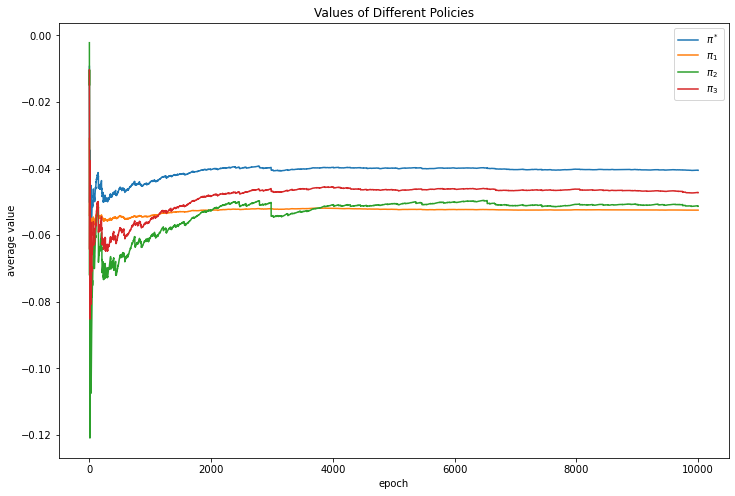

In [2]:
MAX_EPOCH = 10000
T = 10
a = 0.18
b = 0.02
r = 0.1
p = 2./3.
c = 1.
W_0 = 1.
pi_star_average_values = []
pi_1_average_values = []
pi_2_average_values = []
pi_3_average_values = []

for i in range(MAX_EPOCH):
    w0, w1, w2, w3 = 4 * [W_0]
    for t in range(T):
        y = np.random.choice([a, b], p=[p, 1-p])
        w0 = np.log(2)/(0.16 * np.power(1.1,T-t-1)) * (y - r) + w0 * (1 + r)
        w1 = 1. * (y - r) + w1 * (1 + r)
        w2 = 4. * (y - r) + w2 * (1 + r)
        w3 = (3 + np.random.randn()) * (y - r) + w3 * (1 + r)
    pi_star_value = -np.exp(-c * w0)
    pi_1_value = -np.exp(-c * w1)
    pi_2_value = -np.exp(-c * w2)
    pi_3_value = -np.exp(-c * w3)
    if i > 0:
        pi_star_value = i/(i+1) * pi_star_average_values[-1] + pi_star_value/(i+1)
        pi_1_value = i/(i+1) * pi_1_average_values[-1] + pi_1_value/(i+1)
        pi_2_value = i/(i+1) * pi_2_average_values[-1] + pi_2_value/(i+1)
        pi_3_value = i/(i+1) * pi_3_average_values[-1] + pi_3_value/(i+1)
    pi_star_average_values.append(pi_star_value)
    pi_1_average_values.append(pi_1_value)
    pi_2_average_values.append(pi_2_value)
    pi_3_average_values.append(pi_3_value)

plt.figure(figsize=(12, 8))
plt.plot(pi_star_average_values,label='$\pi^*$')
plt.plot(pi_1_average_values,label='$\pi_1$')
plt.plot(pi_2_average_values,label='$\pi_2$')
plt.plot(pi_3_average_values,label='$\pi_3$')
plt.xlabel('epoch')
plt.ylabel('average value')
plt.title('Values of Different Policies')
plt.legend()
plt.show()

In [3]:
#  The average value of the optimal policy after 10000 epochs
pi_star_average_values[-1]

-0.040529294351449724

**Conclusion:**

From this figure, we can clearly see the policy $\pi^*$ dominates the others. The average value of 10000 epochs $\approx$ -0.040529, which is closed to the theoretical value −0.041475.

Meanwile, we should pay attention that, the variance of the values are not small. And it will get significantly larger when $|x_t|$ is larger, since $T = 10$ could amplify the effect of investments.

# 2 Reinforce Learning Algorithm Designing

As the MDP problem has a continuous state space ( $W_t\in \mathbb{R}$ ) and a continuous action space ( $x_t\in \mathbb{R}$ ), we give up table methods which can not precisely model this problem. Besides, we already have the knowledge of the deterministic policy. It naturally comes out that **DDPG** *(Deep Deterministic Policy Gradient)* fits the problem well. In next chapters, we will introduce DDPG and show how to deploy it for our problem.

## 2.1 Summary of DDPG

Deep Deterministic Policy Gradient (DDPG) is an algorithm which concurrently learns a Q-function and a policy. It uses off-policy data and the Bellman equation to learn the Q-function, and uses the Q-function to learn the policy.

This approach is closely connected to Q-learning, and is motivated the same way: if you know the optimal action-value function $Q^*(s,a)$, then in any given state, the optimal action $a^*(s)$ can be found by solving

$$a^*(s) = \arg \max_a Q^*(s,a).$$

DDPG interleaves learning an approximator to $Q^*(s,a)$ with learning an approximator to $a^*(s)$, and it does so in a way which is specifically adapted for environments with continuous action spaces. But what does it mean that DDPG is adapted specifically for environments with continuous action spaces? It relates to how we compute the max over actions in $\max_a Q^*(s,a)$.

When there are a finite number of discrete actions, the max poses no problem, because we can just compute the Q-values for each action separately and directly compare them. (This also immediately gives us the action which maximizes the Q-value.) But when the action space is continuous, we can’t exhaustively evaluate the space, and solving the optimization problem is highly non-trivial. Using a normal optimization algorithm would make calculating $\max_a Q^*(s,a)$ a painfully expensive subroutine. And since it would need to be run every time the agent wants to take an action in the environment, this is unacceptable.

Because the action space is continuous, the function $Q^*(s,a)$ is presumed to be differentiable with respect to the action argument. This allows us to set up an efficient, gradient-based learning rule for a policy $\mu(s)$ which exploits that fact. Then, instead of running an expensive optimization subroutine each time we wish to compute $\max_a Q(s,a)$, we can approximate it with $\max_a Q(s,a) \approx Q(s,\mu(s))$.

DDPG use an *Actor-Critic* network to estimate Action-Value Function $Q^*(s,a)$ (by *Critic*), and actions $a = \mu(s)$ (by *Actor*). *Critic* is updated by minimizing mean-squared TD error, and *Actor* is updated by maxizing Action-Value Function $Q^*(s,\mu(s))$. Replay buffers and soft-replacement are also used in DDPG. The pseudocode is showed as follow:

![DDPG Pseudocode](https://spinningup.openai.com/en/latest/_images/math/5811066e89799e65be299ec407846103fcf1f746.svg#pic_left)

## 2.2 Setup in Asset Allocation Problem

We inherit parameters setting in chapter **1.3**, that is $T = 10,\ a = 0.18,\ b = 0.02,\ r = 0.10,\ p = \dfrac{2}{3},\ c = 1,\ W_0 = 1$.

To specify feature functions and structure of network, we need to leverage the functional form of the closed-form solution for the Action-Value function $(6)$. We observe that we can write this as:

$$Q^*_t(W_t,x_t)=-e^{-A(T-t-1)-B(1+r)^{T-t}W_t}[C\cdot e^{-D(1+r)^{T-t-1}x_t}+(1-C)\cdot e^{-E(1+r)^{T-t-1}x_t}]$$

where

$A = -\ln K = -\ln (\dfrac{2}{3}\cdot 2^{-\frac{1}{2}}+\dfrac{1}{3}\cdot 2^{\frac{1}{2}}) \approx 0.0588915$,

$B = c = 1$,

$C = p = \dfrac{2}{3}$,

$D = c(a-r) = 0.08$,

$E = c(b-r) = -0.08$.

And the Optimal Policy is:

$$ x_t^* = \frac{F}{(1+r)^{T-t-1}} $$

where

$F = \frac{1}{c(a-b)}\cdot \ln \frac{(a-r)p}{(r-b)(1-p)} = \frac{\ln 2}{0.16} \approx 4.33217$.

Then we can select following feature functions to approximate $Q^*_t(W_t,x_t)$:

$\phi_1((t,W_t)) = T-t-1$

$\phi_2((t,W_t)) = (1+r)^{T-t}W_t$

$\phi_3((t,x_t)) = (1+r)^{T-t-1}x_t$

So $Q^*_t(W_t,x_t) = Q^*_t(\phi_1, \phi_2, \phi_3) = -e^{-A\phi_1-B\phi_2}[C\cdot e^{-D\phi_3}+(1-C)\cdot e^{-E\phi_3}]$ is chosen to be *Critic*.

And if we restrict $x_t = \frac{F}{(1+r)^{T-t-1}}$, we can infer that $\phi_3((t,x_t)) \equiv F$. Thus we can choose $\mu_t = (1+r)^{T-t-1}x_t = F$ to be *Actor*,

then $Q^*_t(\phi_1, \phi_2, \phi_3) = Q^*_t(\phi_1, \phi_2, \mu_t)$, which is a stantard DDPG formation.

## 2.3 Code Implememt

In [4]:
# import package and set random seed
import torch
import numpy as np
import torch.nn as nn

seed = 1
torch.manual_seed(seed)
np.random.seed(seed)
torch.set_default_dtype(torch.float)

In [5]:
# Define Actor
class Actor(nn.Module):
    def __init__(self, action_state_dim, action_dim):
        super(Actor, self).__init__()
        
        self.F = torch.nn.Parameter(torch.tensor(4., requires_grad=True))
        
    def replace(self, actor, tau):
        para_iter = self.parameters()
        for para in actor.parameters():
            para_this = next(para_iter)
            para_this.data = (1.-tau) * para_this.data + tau * para.data

    def forward(self, s):
        return self.F * torch.ones_like(s)

In [6]:
# Define Critic
class Critic(nn.Module):

    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        
        self.A = torch.nn.Parameter(torch.tensor(0.1, requires_grad=True))
        self.B = torch.nn.Parameter(torch.tensor(10.0, requires_grad=True))
        self.C = torch.nn.Parameter(torch.tensor(0.6, requires_grad=True))
        self.D = torch.nn.Parameter(torch.tensor(0.1, requires_grad=True))
        self.E = torch.nn.Parameter(torch.tensor(-0.1, requires_grad=True))
    
    def replace(self, crit, tau):
        para_iter = self.parameters()
        for para in crit.parameters():
            para_this = next(para_iter)
            para_this.data = (1.-tau) * para_this.data + tau * para.data

    def forward(self, s, a):
        
        s1, s2 = torch.split(s, split_size_or_sections=1, dim=1)
        return -torch.exp(-self.A * s1 - self.B * s2) * (self.C * torch.exp(-self.D * a) + (1.-self.C) * torch.exp(-self.E * a))

In [7]:
class DDPG(object):
    def __init__(self, state_dim, action_state_dim, action_dim, replacement,memory_capacity=50000,gamma=1.,lr_a=0.0005, lr_c=0.0005,batch_size=10000) :
        super(DDPG, self).__init__()
        self.state_dim = state_dim
        self.action_state_dim = action_state_dim
        self.action_dim = action_dim
        self.memory_capacity = memory_capacity
        self.replacement = replacement
        self.t_replace_counter = 0
        self.gamma = gamma
        self.penal = np.log(2)/0.16
        self.lr_a = lr_a
        self.lr_c = lr_c
        self.batch_size = batch_size

        # Replay Buffer
        self.memory = np.zeros((memory_capacity, (state_dim + action_state_dim) * 2 + action_dim + 2)) # (s,a,r,s',d)
        self.pointer = 0
        # Define Actor network
        self.actor = Actor(action_state_dim, action_dim)
        self.actor_target = Actor(action_state_dim, action_dim)
        # Define Critic network
        self.critic = Critic(state_dim,action_dim)
        self.critic_target = Critic(state_dim,action_dim)
        # Define Optimizer
        self.aopt = torch.optim.Adam(self.actor.parameters(), lr=lr_a)
        self.copt = torch.optim.Adam(self.critic.parameters(), lr=lr_c)
        # Define Loss Function
        self.mse_loss = nn.MSELoss()

    def sample(self):
        indices = np.random.choice(self.memory_capacity, size=self.batch_size)
        return self.memory[indices, :] 

    def choose_action(self, s):
        s = torch.FloatTensor(s)
        action = self.actor(s)
        return action.detach().numpy()

    def learn(self):

        # soft replacement and hard replacement
        if self.replacement['name'] == 'soft':
            # soft replacement means take replacement every step
            tau = self.replacement['tau']
            self.actor_target.replace(self.actor, tau)
            self.critic_target.replace(self.critic, tau)
            
        else:
            # hard replacement means take replacement after a number of steps
            if self.t_replace_counter % self.replacement['rep_iter'] == 0:
                self.t_replace_counter = 0
                self.actor_target.replace(self.actor, 1.)
                self.critic_target.replace(self.critic, 1.)
            self.t_replace_counter += 1

        # Sample bacth data from replay buffer
        bm = self.sample()
        bs = torch.FloatTensor(bm[:, : self.state_dim])
        bas = torch.FloatTensor(bm[:, self.state_dim: self.state_dim + self.action_state_dim])
        ba = torch.FloatTensor(bm[:, self.state_dim + self.action_state_dim: self.state_dim + self.action_state_dim + self.action_dim])
        br = torch.FloatTensor(bm[:, -self.state_dim - self.action_state_dim - 2: -self.state_dim - self.action_state_dim - 1])
        bs_ = torch.FloatTensor(bm[:,-self.state_dim - self.action_state_dim - 1: -self.action_state_dim - 1])
        bas_ = torch.FloatTensor(bm[:,-self.action_state_dim-1: -1])
        bd = torch.FloatTensor(bm[:,-1:])
        
        # Train Actor
        a = self.actor(bas)
        q = self.critic(bs, a)
        a_loss = -torch.mean(q) + 0.00001 * torch.mean(torch.abs(a - self.penal))
        self.aopt.zero_grad()
        a_loss.backward(retain_graph=True)
        self.aopt.step()
        
        # Train Critic
        a_ = self.actor_target(bas_)
        q_ = self.critic_target(bs_, a_)
        q_target = br + self.gamma * (1 - bd) * q_
        q_eval = self.critic(bs, ba)
        td_error = self.mse_loss(q_target,q_eval)
        self.copt.zero_grad()
        td_error.backward()
        self.copt.step()

    def store_transition(self, s, sa, a, r, s_, sa_, d):
        transition = np.hstack((s, sa, a, [r], s_, sa_, [d]))
        index = self.pointer % self.memory_capacity
        self.memory[index, :] = transition
        self.pointer += 1

In [8]:
# Create the environment of asset dynamics
class Env:
    def __init__(self, T, a, b, r, p, c, W_0):
        self.t = 0
        self.W = W_0
        self.W_0 = W_0
        self.T = T
        self.a = a
        self.b = b
        self.r = r
        self.p = p
        self.c = c
        self.done = False
        
    def utility(self, W):
        return -np.exp(-self.c * W)
    
    def reset(self):
        self.t = 0
        self.W = self.W_0
        self.done = False
        return [self.t, self.W]
    
    def step(self, x):
        if self.done:
            return False
        W_new = x[0] * (np.random.choice((self.a, self.b), p=(self.p, 1-self.p)) - self.r) + self.W * (1 + self.r)
        if self.t == 0:
            reward = self.utility(W_new)
        else:
            reward = self.utility(W_new) - self.utility(self.W)
        self.t += 1
        self.W = W_new
        if self.t > self.T - 1:
            self.done = True
        return [self.t, self.W], reward, self.done

In [9]:
# Define feature function
def feature_select(s, is_actor = False, T = 10, r = 0.1):
    if is_actor:
        return [1]
    else:
        return [T - s[0] - 1, np.power(1+r, T-s[0]) * s[1]]

In [10]:
if __name__ == '__main__':

    # hyper parameters
    MAX_EPISODES = 15000
    MAX_EP_STEPS = 20
    MEMORY_CAPACITY = 5000
    BATCH_SIZE=2000
    LR_A=0.0001
    LR_C=0.0001
    REPLACEMENT = [
        dict(name='soft', tau=0.01),
        dict(name='hard', rep_iter=600)
    ][0]  # you can try different target replacement strategies
    
    T = 10
    a = 0.18
    b = 0.02
    r = 0.1
    p = 2./3.
    c = 10.
    W_0 = 1.
    
    # train
    env = Env(T, a, b, r, p, c, W_0)

    s_dim = 2
    as_dim = 1
    a_dim = 1
    ddpg = DDPG(state_dim=s_dim,
                action_state_dim = as_dim,
                action_dim=a_dim,
                replacement=REPLACEMENT,
                lr_a=LR_A,
                lr_c=LR_C,
                memory_capacity=MEMORY_CAPACITY,
                batch_size=BATCH_SIZE)
    
    average_values = []
    last_investments = []
    for i in range(MAX_EPISODES):
        s = env.reset()
        ep_reward = 0
        for j in range(MAX_EP_STEPS):
            # Add exploration noise
            s_s = feature_select(s, is_actor = False, T = env.T, r = env.r)
            a_s = feature_select(s, is_actor = True, T = env.T, r = env.r)
            a = ddpg.choose_action(a_s)
            x = a * np.power(1 + env.r, env.t - env.T + 1)

            s_, reward, done = env.step(x)
            
            s_s_ = feature_select(s_, is_actor = False, T = env.T, r = env.r)
            a_s_ = feature_select(s_, is_actor = True, T = env.T, r = env.r)
            ddpg.store_transition(s_s, a_s, a, reward, s_s_, a_s_, done)

            ddpg.learn()
            
            s = s_
            ep_reward += reward
            if done or j == MAX_EP_STEPS - 1:
                if i > 0:
                    ep_reward = i/(i+1) * average_values[-1] + ep_reward/(i+1)
                average_values.append(ep_reward)
                last_investments.append(x)
                if i % 50 == 0:
                    print('Episode:', i, ' Total Reward:', ep_reward, 'Last investment:', x)
                break

Episode: 0  Total Reward: -5.438570596803339e-12 Last investment: [3.999101]
Episode: 50  Total Reward: -2.1846168584682578e-05 Last investment: [3.9576638]
Episode: 100  Total Reward: -1.1031263943249726e-05 Last investment: [3.9439487]
Episode: 150  Total Reward: -7.378588364359447e-06 Last investment: [3.9722977]
Episode: 200  Total Reward: -5.553496723216511e-06 Last investment: [4.03059]
Episode: 250  Total Reward: -4.456000836666053e-06 Last investment: [4.0934844]
Episode: 300  Total Reward: -3.7342421689402924e-06 Last investment: [4.1520276]
Episode: 350  Total Reward: -1.0229586855830028e-05 Last investment: [4.2232547]
Episode: 400  Total Reward: -8.965462548697166e-06 Last investment: [4.27858]
Episode: 450  Total Reward: -0.010939102337999215 Last investment: [4.3145504]
Episode: 500  Total Reward: -0.009847386513551055 Last investment: [4.325708]
Episode: 550  Total Reward: -0.008953794321022116 Last investment: [4.3257113]
Episode: 600  Total Reward: -0.00820889563978102

Episode: 5150  Total Reward: -0.0025859918419276436 Last investment: [4.193217]
Episode: 5200  Total Reward: -0.0025611313192542926 Last investment: [4.219657]
Episode: 5250  Total Reward: -0.0025367450045872624 Last investment: [4.2545776]
Episode: 5300  Total Reward: -0.002513596184298282 Last investment: [4.2989726]
Episode: 5350  Total Reward: -0.0024901110062268087 Last investment: [4.3321667]
Episode: 5400  Total Reward: -0.002467058696945029 Last investment: [4.332133]
Episode: 5450  Total Reward: -0.0024444292841357745 Last investment: [4.3321447]
Episode: 5500  Total Reward: -0.002422212277099988 Last investment: [4.332174]
Episode: 5550  Total Reward: -0.002400394478022745 Last investment: [4.3321624]
Episode: 5600  Total Reward: -0.002378968247482076 Last investment: [4.332167]
Episode: 5650  Total Reward: -0.0023579211781276635 Last investment: [4.332186]
Episode: 5700  Total Reward: -0.0023372422884185935 Last investment: [4.332136]
Episode: 5750  Total Reward: -0.00231692

Episode: 10300  Total Reward: -0.0018875724262568164 Last investment: [4.6481667]
Episode: 10350  Total Reward: -0.0018784546016522232 Last investment: [4.66648]
Episode: 10400  Total Reward: -0.0018724549017185644 Last investment: [4.6863904]
Episode: 10450  Total Reward: -0.0018634966474366968 Last investment: [4.6890507]
Episode: 10500  Total Reward: -0.001854627077251798 Last investment: [4.686107]
Episode: 10550  Total Reward: -0.0018458382150498501 Last investment: [4.6871834]
Episode: 10600  Total Reward: -0.0018371322541938235 Last investment: [4.6922765]
Episode: 10650  Total Reward: -0.0018285096930304304 Last investment: [4.685804]
Episode: 10700  Total Reward: -0.0018199660555257597 Last investment: [4.6881523]
Episode: 10750  Total Reward: -0.001814496419088484 Last investment: [4.689183]
Episode: 10800  Total Reward: -0.0018060967550331123 Last investment: [4.6937447]
Episode: 10850  Total Reward: -0.0017977778508779451 Last investment: [4.69502]
Episode: 10900  Total Rew

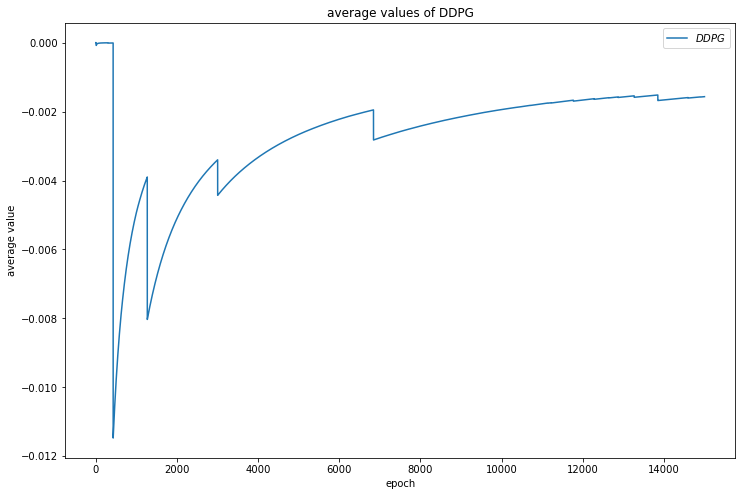

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.plot(average_values,label='$DDPG$')
plt.xlabel('epoch')
plt.ylabel('average value')
plt.title('average values of DDPG')
plt.legend()
plt.show()

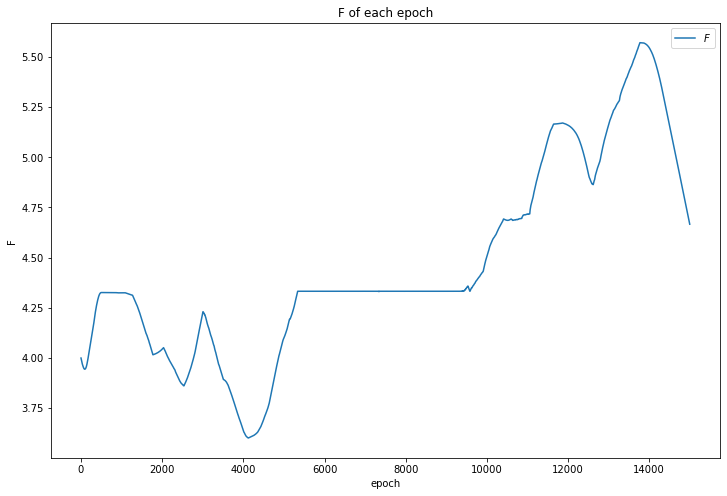

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(last_investments,label='$F$')
plt.xlabel('epoch')
plt.ylabel('F')
plt.title('F of each epoch')
plt.legend()
plt.show()

## 2.4 Conclusion

The result shows DDPG can be used to solve this asset allocation problem. The average value of the problem using DDPG seems going to converge. However, we need to pay attention that the Policy Function (*Actor*) fluctuate a lot around optimal $F=4.33217$, which could lead to the unstability of the whole system. It is because the huge randomness brought by multi-steps $T$, and a two-point distribution of $Y_t$. It is easy to generate wrong signal to update *Critic* and *Actor* in an improper way.